## 1. Fitting Ne lines in a loop
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- The easiest way to install diad fit is by removing the #, and running this once per computer. When I update the code, you'll need to get the new tag off GitHub:
https://github.com/PennyWieser/DiadFit/tags
Right click on the top one, over the 'zip' icon, click copy link address
![image.png](attachment:5a0e0d97-4380-4cb2-bf26-d0ab6ee7458a.png)

In [1]:
#!pip install --upgrade "https://github.com/PennyWieser/DiadFit/archive/refs/tags/0.0.17.zip"

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.22'

## Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [3]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, cut_off_intensity=1000)
df_Ne

,Raman_shift (cm-1),Intensity,Ne emission line in air
0,817.650482,1500.000000,556.244160
1,818.699523,5000.000000,556.276620
9,1117.086987,5000.000000,565.665880
13,1220.000000,1000.444444,568.978151
14,1220.107463,1500.000000,568.981630
16,1309.425403,1500.000000,571.887980
17,1310.480205,5000.000000,571.922480
20,1398.915133,5000.000000,574.829850
24,1447.564622,7000.000000,576.441880
27,1567.204978,5000.000000,580.444960


## Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for the line shift you have written down

In [4]:
#select lines to fit
pick1=1117
pick2=1400


ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
                                      line1_shift=pick1, line2_shift=pick2,
                                     cut_off_intensity=1000)
ideal_split

,Ne_Split,Line_1,Line_2,Entered Pos Line 1,Entered Pos Line 2
0,281.828145,1117.086987,1398.915133,1117,1400


## Find your files

In [5]:
path=r"G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\Repeated_Acquisitions"
filename='Ne_timeseries_10-03-22.txt'


In [6]:
files=pf.get_data(path=path,
                       filename=filename, filetype='headless_txt')
test=np.column_stack((files[:, 0], files[:, 1]))

In [7]:
len(files)

1024

Biggest 6 peaks:


,pos,height
64,1447.562937,47142.332030
58,1398.571000,7379.666504
80,1566.680386,6382.666504
10,1116.242122,3606.333252
30,1219.729035,3203.333252
40,1309.925385,2045.666626


selected Peak 1 Pos
1116.242122
selected Peak 2 Pos
1398.571


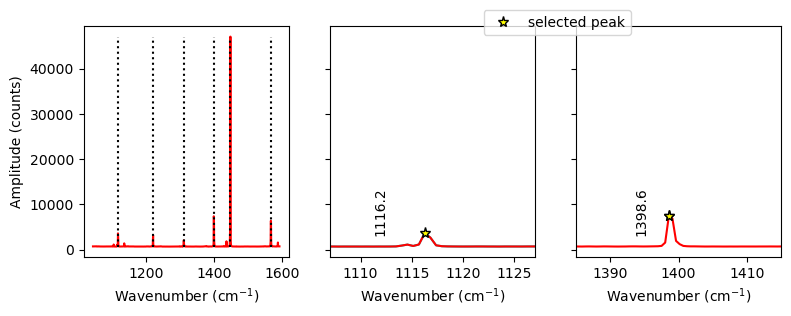

In [8]:
# Specify the approximate peak positions of the lines you are interested in
# If your drift is off the real positions, you'll have to tweak these numbers
peak1_cent=pick1
peak2_cent=pick2


Ne, df_sort_Ne_trim, nearest_pk1, nearest_pk2=pf.plot_Ne_lines(Ne_array=test,
n_peaks=6, peak1_cent=peak1_cent, peak2_cent=peak2_cent,
height=10, threshold=0.6, distance=1, prominence=10, width=1, exclude_range_1=None,
exclude_range_2=None)

## Now tweak the fit for this 1 example
- Most important things, the number of peaks you want for 1117, and the offset for this peak (LH_offset_min)
- By default, the function applies the fit to all the points inside the outermost background positions. This can be trimmed using x_span_pk1_override, and x_span_pk2_override, 

## You can tweak parameters here
- The default parameters may work, you can see what those are here:

In [9]:
pf.Ne_peak_config()

Ne_peak_config(N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), x_range_baseline=20, y_range_baseline=200, pk1_amplitude=100, pk2_amplitude=100, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

- You can also overwrite any of these, the most likely things you'll want to overwrite are the background positions, or the amplitude

In [11]:
Ne_Config=pf.Ne_peak_config(LH_offset_mini=[2, 5], 
lower_bck_pk1=(-50, -30), upper_bck1_pk1=[7, 13], upper_bck2_pk1=[50, 80],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[20, 50], upper_bck2_pk2=[20, 50],
x_range_peak=15, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10])
Ne_Config

Ne_peak_config(N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -30), upper_bck1_pk1=[7, 13], upper_bck2_pk1=[50, 80], lower_bck_pk2=[-40, -30], upper_bck1_pk2=[20, 50], upper_bck2_pk2=[20, 50], x_range_baseline=20, y_range_baseline=200, pk1_amplitude=100, pk2_amplitude=100, x_range_peak=15, x_range_residual=7, LH_offset_mini=[2, 5], x_span_pk1=[-10, 8], x_span_pk2=[-10, 10])

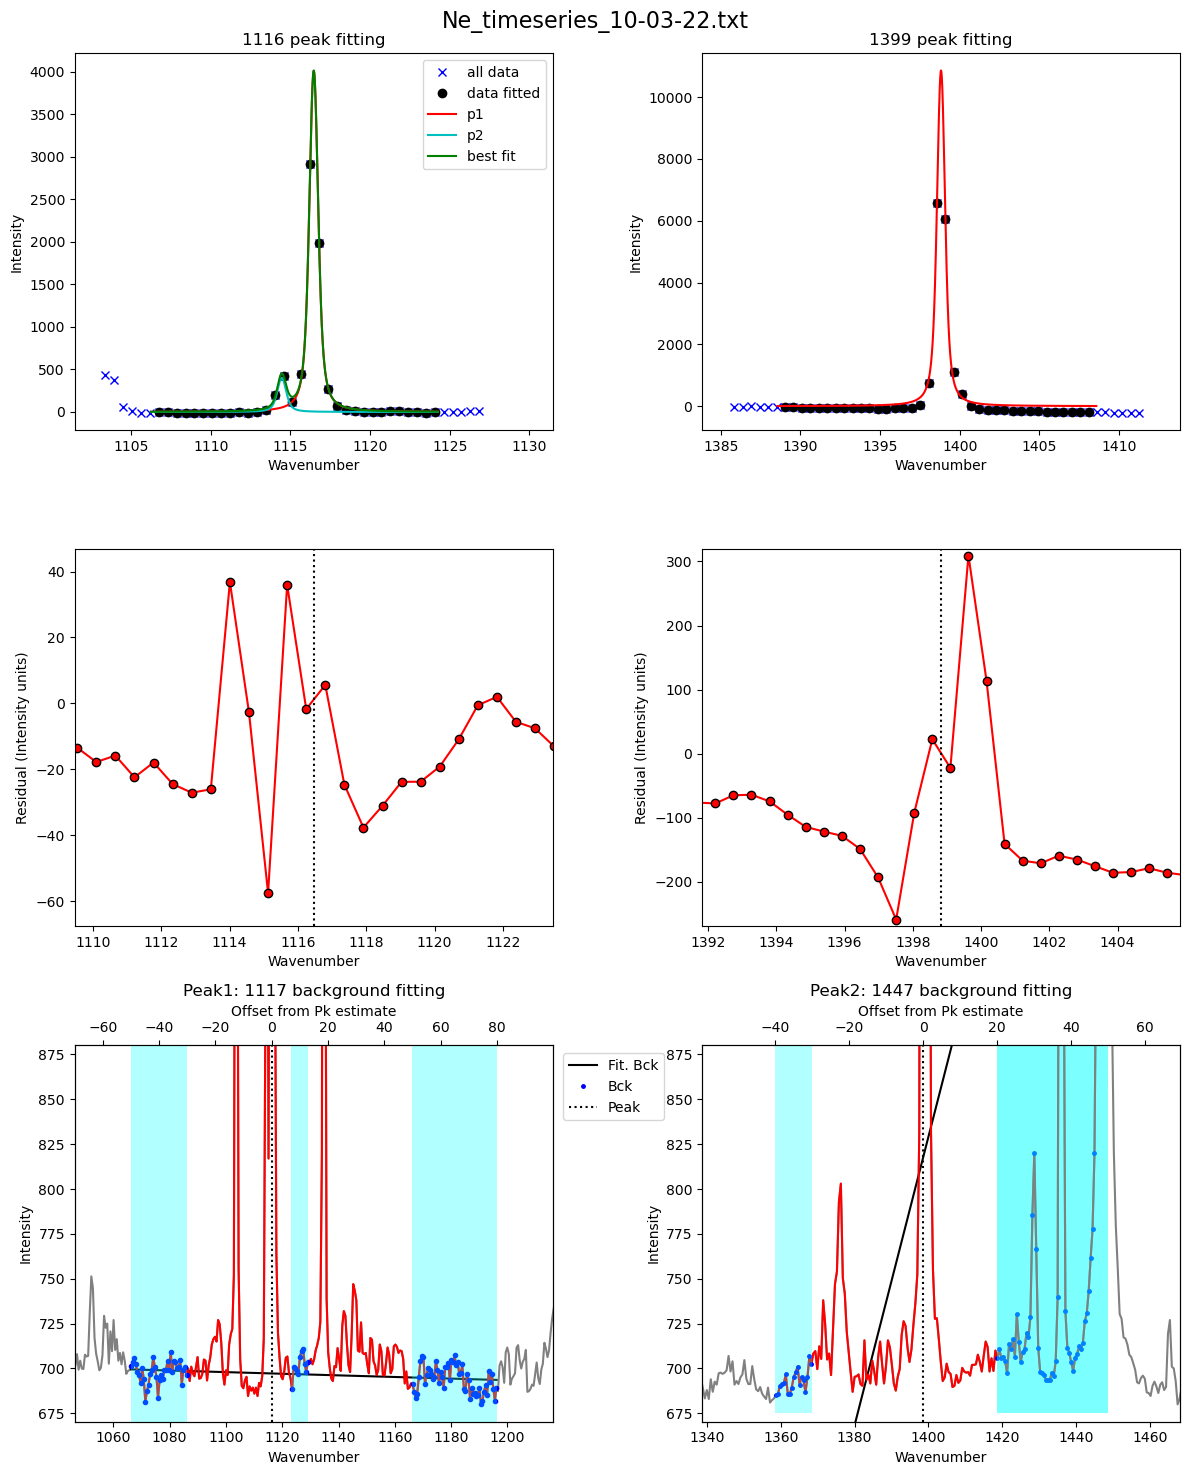

In [12]:
# You also need to set whether you want 1 peak or 2 for the LH diad
if pick1==1117:
    peaks_1=2
else:
    peaks_1=1

#peaks_1=2

df_test=pf.fit_Ne_lines(  
    config=Ne_Config, peaks_1=peaks_1,
    Ne=Ne, prefix=None, path=path, filename=filename,
    Ne_center_1=nearest_pk1, Ne_center_2=nearest_pk2,
    DeltaNe_ideal=ideal_split['Ne_Split'])                                                                 
                                                                     
        
#config: Ne_peak_config=Ne_peak_config(),

## Now you can loop over all files using these parameters
- Most important thing you can change is plot_figure=False, much quicker, but wont save or show figures, plot_figure=True will)
- If you need, you can add other parameters in the loop here. 

In [13]:
np.shape(files)

(1024, 576)

In [14]:
files[0]

array([1042.545976,  719.      ,  718.      ,  718.333313,  724.333313,
        722.      ,  716.333313,  723.666687,  731.333313,  723.666687,
        723.      ,  725.666687,  724.666687,  717.333313,  731.      ,
        722.333313,  724.666687,  722.333313,  725.      ,  720.333313,
        722.666687,  721.333313,  727.666687,  724.      ,  728.666687,
        720.666687,  726.      ,  725.666687,  719.666687,  723.333313,
        719.      ,  725.      ,  723.      ,  728.333313,  726.      ,
        724.      ,  722.666687,  718.      ,  726.      ,  720.666687,
        719.333313,  717.333313,  721.333313,  723.666687,  719.      ,
        719.      ,  728.      ,  721.666687,  719.333313,  722.      ,
        724.      ,  727.      ,  719.666687,  730.      ,  722.      ,
        724.333313,  721.333313,  719.666687,  723.666687,  715.      ,
        722.333313,  714.333313,  718.333313,  721.333313,  719.333313,
        724.333313,  717.      ,  716.      ,  716.      ,  731.

In [15]:
# plot_figure=False # Means doesnt make figures, lot faster. 
# save_excel=True # Saves to excel
# save_clipboard=True # Copies to clipboard

# df = pd.DataFrame([])
# for i in range(0, len(files)):
    
#     test=np.column_stack((files[:, 0], files[:, i+1]))
#     print('working on ' + str(i))

    
#     data=pf.fit_Ne_lines(  
#     config=Ne_Config, peaks_1=peaks_1,
#     Ne=test, filename=filename, path=path, prefix=None,
#     Ne_center_1=nearest_pk1, Ne_center_2=nearest_pk2,
#     DeltaNe_ideal=ideal_split['Ne_Split'], plot_figure=False) 


#     df = df.append(data)
# df2=df.reset_index(drop=True)

In [16]:
np.shape(files)

(1024, 576)

In [17]:
files[:, 0]

array([1042.545976, 1043.112314, 1043.678594, ..., 1591.175541,
       1591.684529, 1592.193462])

In [18]:
files[:, 1]

array([719.      , 727.      , 725.      , ..., 741.333313, 732.      ,
       724.      ])

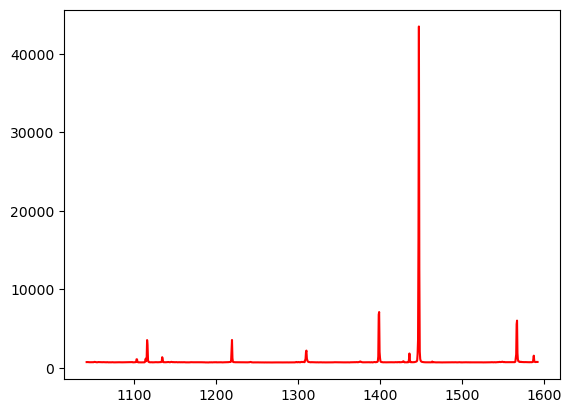

In [19]:
plt.plot(files[:, 0], files[:, 5], '-r')

In [20]:
df2=pf.loop_Ne_lines(files=files, path=path, filetype='headless_txt',
config=Ne_Config, peaks_1=2, Ne=Ne, Ne_center_1=nearest_pk1,
Ne_center_2=nearest_pk2, DeltaNe_ideal=ideal_split['Ne_Split'],
plot_figure=False, save_clipboard=False)

100%|████████████████████████████████████████████████████████████████████████████████| 574/574 [01:26<00:00,  6.64it/s]


(0.99765, 0.99795)

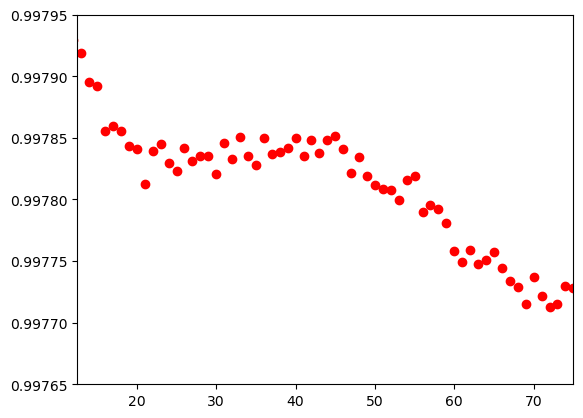

In [32]:
plt.plot( df2.index, df2['Ne_Corr'],'or')
plt.xlim([100/8, 600/8])
x=0.9978
plt.ylim([x-0.00015, x+0.00015])

In [ ]:
len(df2)

In [ ]:
df2=df.reset_index(drop=True)

In [ ]:
plt.plot(df2['Ne_Corr'].index, df2['Ne_Corr'], 'or')

In [ ]:
Corr_Ne=103*df2['Ne_Corr']

In [ ]:
files=df2.loc[df2['Ne_Corr'].between(0.9977,0.9985)]

In [12]:
pf.plot_Ne_corrections(df=df2, x_axis=None, marker='o', mec='k',
mfc='r')

nm=str(peak1_cent)+'_'+str(peak2_cent) #string name for excel file
df2.to_excel(nm+".xlsx")

NameError: name 'df2' is not defined

In [ ]:
Density=pf.calculate_density_cornell(temp='SupCrit', Split=Corr_Ne)

In [ ]:
plt.plot(df2['Ne_Corr'].index, Density['Preferred D'], '-r')
plt.ylabel('Theoretical density for split=103 cm-1-')
plt.xlabel('Acqusition #')

## Loading time

In [ ]:
path=r'G:\My Drive\Berkeley_NEW\Raman\2022_09_26_longNeLine1'
aranet=pd.read_excel(path+str('/')+'2022_09_26_27_LongNeLineAcqusiion.xls', sheet_name='Aranet')

In [ ]:
aranet_t=aranet['time'].values
aranet_T=aranet['Temperature(Â°C)']

In [ ]:
Raman_t=aranet_t[0]+(300+45*3)*df2.index/(24*60*60)

In [ ]:
300*df2.index/(24*60*60)

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize = (8,5))
ax1.plot(aranet_t, aranet_T, 'og')
ax2=ax1.twinx()
reas=df2['Ne_Corr'].between(0.998, 1)
ax2.plot(Raman_t[reas], df2['Ne_Corr'][reas], '-r')